--- 24.466691970825195 seconds_pre-store ---
--- 25.387871026992798 seconds_start se ---
--- 25.619036197662354 seconds_se over-amp start ---
--- 69.19059801101685 seconds_amp over ---
--- 69.19174814224243 seconds_plots ---


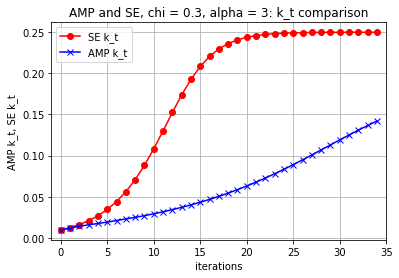

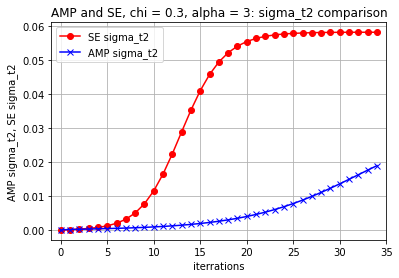

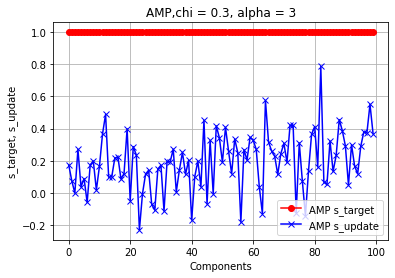

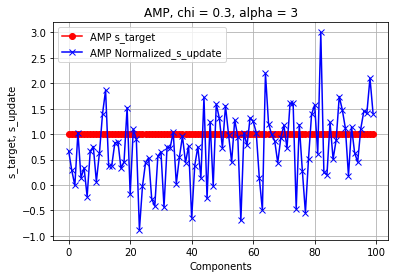

--- 70.86576199531555 seconds_plots over ---


In [15]:
# Homework6(AMP and SE - pre-store y^* second version fixed chi comparison) - alhpa=3
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

#hash table: pre-store all the possible y^*
def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

hash_y = dict()
keyIdx = []
for i in np.arange(0,20,0.0001):
    keyIdx.append(round(i,4))
for j in keyIdx:
    hash_y[j]=y_s(j,0.3)
print("--- %s seconds_pre-store ---" % (time.time() - start_time))

#sampling
n = 100  # dimension
m = 300  # data
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)

def F(p, t):
    if p>0:
        return hash_y[p]/np.sqrt(t)
    else:
        return -hash_y[abs(p)]/np.sqrt(t)

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def update_p(s, p, chi):
    p_d = np.zeros(m)
    for u in range(m):
        p_d[u] = round((1/np.sqrt(n))*x[u]@s - chi*F(p[u],chi),4)
    return p_d

def update_s(s, p, chi):
    s_d = np.zeros(n)
    for i in range(n):
        sum_ = 0
        for j in range(m):
            sum_ += chi*((1/np.sqrt(n))*x[j][i]*F(p[j],chi) -(1/n)*s[i]*x[j][i]**2*T(p[j],chi))
        s_d[i] = sum_
    return s_d

def amp2(chi):
    s_0 = np.zeros(n)  
    p_0 = np.zeros(m)
    eps=1e-6
    iter_amp2 = 0
    p_new = np.zeros(m)
    s_new = 0.01*np.ones(n)
    def sigma2_update(s_new):
        sigma2_up = 0
        for i in range(n):
            sigma2_up += LA.norm(s_new[i] - k_collect_amp2[iter_amp2])**2/n
        return sigma2_up
    while LA.norm(s_new[0] - s_0[0])>eps:
        p_collect_amp2.append(p_new)
        s_collect_amp2.append(s_new)
        k_collect_amp2.append(s_new@s_Ori/n)
        sigma2_collect_amp2.append(sigma2_update(s_new))
        s_0 = s_new
        p_0 = p_new
        p_new = update_p(s_0,p_0, chi)
        s_new = update_s(s_0,p_new, chi)
        iter_amp2 +=1
    return s_collect_amp2,p_collect_amp2,k_collect_amp2,sigma2_collect_amp2,iter_amp2

def se2(chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in range(-50,51,1):
            sum_f += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)/np.sqrt(2*np.pi)
            sum_f2 += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)**2/np.sqrt(2*np.pi)
        k_new = alpha*chi*sum_f
        sigma_new = alpha*chi**2*sum_f2
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

print("--- %s seconds_start se ---" % (time.time() - start_time))
se2_update = se2(0.3)
print("--- %s seconds_se over-amp start ---" % (time.time() - start_time))
amp2_update = amp2(0.3)
print("--- %s seconds_amp over ---" % (time.time() - start_time))

idx_se2 = []
for index in range(se2_update[2]+1):
    idx_se2.append(index)

idx_amp2 = []
for index in range(amp2_update[4]):
    idx_amp2.append(index)

idx = []
for index in range(n):
    idx.append(index)

iterMin = min(len(idx_se2),len(idx_amp2))   
print("--- %s seconds_plots ---" % (time.time() - start_time))

#figure-1    
plt.plot(idx_se2[:iterMin],se2_update[0][:iterMin],c="r",label="SE k_t",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[2][:iterMin],c="b",label="AMP k_t",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: k_t comparison")
plt.ylabel("AMP k_t, SE k_t")
plt.xlim(-1,iterMin)
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()

#figure-2
plt.plot(idx_se2[:iterMin],se2_update[1][:iterMin],c="r",label="SE sigma_t2",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[3][:iterMin],c="b",label="AMP sigma_t2",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: sigma_t2 comparison")
plt.ylabel("AMP sigma_t2, SE sigma_t2")
plt.xlabel("iterrations")
plt.xlim(-1,iterMin)
plt.grid()
plt.legend()
plt.show()

#figure-3
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,amp2_update[0][-1],c="b",label="AMP s_update",marker="x")
plt.title("AMP,chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()

#figure-4 Normalized_S
normalized_S = np.sqrt(n)* amp2_update[0][-1]/LA.norm(amp2_update[0][-1])
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,normalized_S,c="b",label="AMP Normalized_s_update",marker="x")
plt.title("AMP, chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()
print("--- %s seconds_plots over ---" % (time.time() - start_time))

--- 25.239742040634155 seconds_pre-store ---
--- 46.1853289604187 seconds_start se ---
--- 46.339158058166504 seconds_se over-amp start ---
--- 283.904865026474 seconds_amp over ---
--- 283.90536189079285 seconds_plots ---


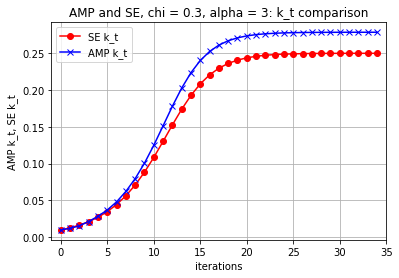

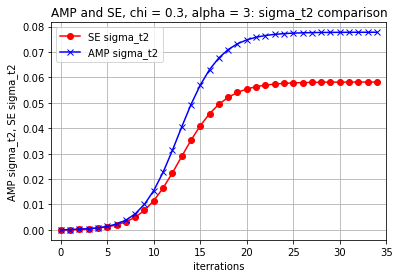

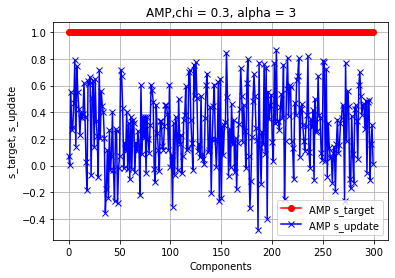

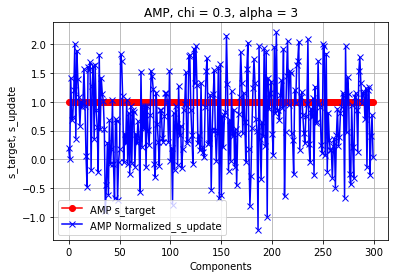

--- 285.0950689315796 seconds_plots over ---


In [16]:
# Homework6(AMP and SE - pre-store y^* second version fixed chi comparison) - alhpa=3
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

#hash table: pre-store all the possible y^*
def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

hash_y = dict()
keyIdx = []
for i in np.arange(0,20,0.0001):
    keyIdx.append(round(i,4))
for j in keyIdx:
    hash_y[j]=y_s(j,0.3)
print("--- %s seconds_pre-store ---" % (time.time() - start_time))

#sampling
n = 300  # dimension
m = 900  # data
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)

def F(p, t):
    if p>0:
        return hash_y[p]/np.sqrt(t)
    else:
        return -hash_y[abs(p)]/np.sqrt(t)

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def update_p(s, p, chi):
    p_d = np.zeros(m)
    for u in range(m):
        p_d[u] = round((1/np.sqrt(n))*x[u]@s - chi*F(p[u],chi),4)
    return p_d

def update_s(s, p, chi):
    s_d = np.zeros(n)
    for i in range(n):
        sum_ = 0
        for j in range(m):
            sum_ += chi*((1/np.sqrt(n))*x[j][i]*F(p[j],chi) -(1/n)*s[i]*x[j][i]**2*T(p[j],chi))
        s_d[i] = sum_
    return s_d

def amp2(chi):
    s_0 = np.zeros(n)  
    p_0 = np.zeros(m)
    eps=1e-6
    iter_amp2 = 0
    p_new = np.zeros(m)
    s_new = 0.01*np.ones(n)
    def sigma2_update(s_new):
        sigma2_up = 0
        for i in range(n):
            sigma2_up += LA.norm(s_new[i] - k_collect_amp2[iter_amp2])**2/n
        return sigma2_up
    while LA.norm(s_new[0] - s_0[0])>eps:
        p_collect_amp2.append(p_new)
        s_collect_amp2.append(s_new)
        k_collect_amp2.append(s_new@s_Ori/n)
        sigma2_collect_amp2.append(sigma2_update(s_new))
        s_0 = s_new
        p_0 = p_new
        p_new = update_p(s_0,p_0, chi)
        s_new = update_s(s_0,p_new, chi)
        iter_amp2 +=1
    return s_collect_amp2,p_collect_amp2,k_collect_amp2,sigma2_collect_amp2,iter_amp2

def se2(chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in range(-50,51,1):
            sum_f += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)/np.sqrt(2*np.pi)
            sum_f2 += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)**2/np.sqrt(2*np.pi)
        k_new = alpha*chi*sum_f
        sigma_new = alpha*chi**2*sum_f2
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

print("--- %s seconds_start se ---" % (time.time() - start_time))
se2_update = se2(0.3)
print("--- %s seconds_se over-amp start ---" % (time.time() - start_time))
amp2_update = amp2(0.3)
print("--- %s seconds_amp over ---" % (time.time() - start_time))

idx_se2 = []
for index in range(se2_update[2]+1):
    idx_se2.append(index)

idx_amp2 = []
for index in range(amp2_update[4]):
    idx_amp2.append(index)

idx = []
for index in range(n):
    idx.append(index)

iterMin = min(len(idx_se2),len(idx_amp2))   
print("--- %s seconds_plots ---" % (time.time() - start_time))

#figure-1    
plt.plot(idx_se2[:iterMin],se2_update[0][:iterMin],c="r",label="SE k_t",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[2][:iterMin],c="b",label="AMP k_t",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: k_t comparison")
plt.ylabel("AMP k_t, SE k_t")
plt.xlim(-1,iterMin)
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()

#figure-2
plt.plot(idx_se2[:iterMin],se2_update[1][:iterMin],c="r",label="SE sigma_t2",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[3][:iterMin],c="b",label="AMP sigma_t2",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: sigma_t2 comparison")
plt.ylabel("AMP sigma_t2, SE sigma_t2")
plt.xlabel("iterrations")
plt.xlim(-1,iterMin)
plt.grid()
plt.legend()
plt.show()

#figure-3
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,amp2_update[0][-1],c="b",label="AMP s_update",marker="x")
plt.title("AMP,chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()

#figure-4 Normalized_S
normalized_S = np.sqrt(n)* amp2_update[0][-1]/LA.norm(amp2_update[0][-1])
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,normalized_S,c="b",label="AMP Normalized_s_update",marker="x")
plt.title("AMP, chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()
print("--- %s seconds_plots over ---" % (time.time() - start_time))

--- 23.723316431045532 seconds_pre-store ---
--- 186.5230553150177 seconds_start se ---
--- 186.75248622894287 seconds_se over-amp start ---
--- 698.7583250999451 seconds_amp over ---
--- 698.7590272426605 seconds_plots ---


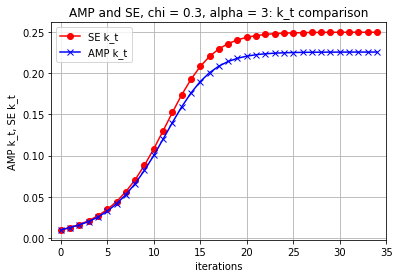

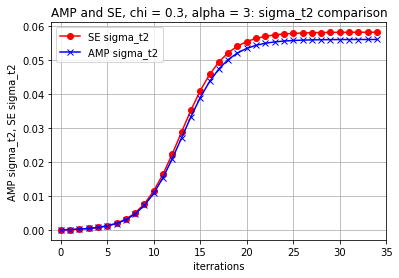

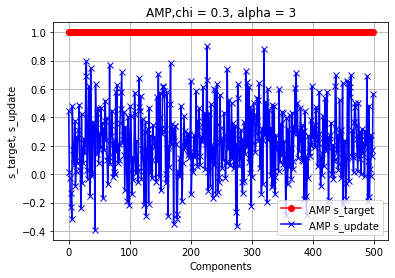

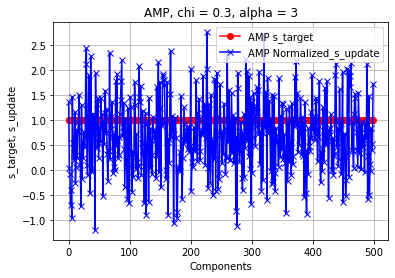

--- 700.2274241447449 seconds_plots over ---


In [13]:
# Homework6(AMP and SE - pre-store y^* second version fixed chi comparison) - alhpa=3
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

#hash table: pre-store all the possible y^*
def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

hash_y = dict()
keyIdx = []
for i in np.arange(0,20,0.0001):
    keyIdx.append(round(i,4))
for j in keyIdx:
    hash_y[j]=y_s(j,0.3)
print("--- %s seconds_pre-store ---" % (time.time() - start_time))

#sampling
n = 500  # dimension
m = 1500  # data
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)

def F(p, t):
    if p>0:
        return hash_y[p]/np.sqrt(t)
    else:
        return -hash_y[abs(p)]/np.sqrt(t)

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def update_p(s, p, chi):
    p_d = np.zeros(m)
    for u in range(m):
        p_d[u] = round((1/np.sqrt(n))*x[u]@s - chi*F(p[u],chi),4)
    return p_d

def update_s(s, p, chi):
    s_d = np.zeros(n)
    for i in range(n):
        sum_ = 0
        for j in range(m):
            sum_ += chi*((1/np.sqrt(n))*x[j][i]*F(p[j],chi) -(1/n)*s[i]*x[j][i]**2*T(p[j],chi))
        s_d[i] = sum_
    return s_d

def amp2(chi):
    s_0 = np.zeros(n)  
    p_0 = np.zeros(m)
    eps=1e-6
    iter_amp2 = 0
    p_new = np.zeros(m)
    s_new = 0.01*np.ones(n)
    def sigma2_update(s_new):
        sigma2_up = 0
        for i in range(n):
            sigma2_up += LA.norm(s_new[i] - k_collect_amp2[iter_amp2])**2/n
        return sigma2_up
    while LA.norm(s_new[0] - s_0[0])>eps:
        p_collect_amp2.append(p_new)
        s_collect_amp2.append(s_new)
        k_collect_amp2.append(s_new@s_Ori/n)
        sigma2_collect_amp2.append(sigma2_update(s_new))
        s_0 = s_new
        p_0 = p_new
        p_new = update_p(s_0,p_0, chi)
        s_new = update_s(s_0,p_new, chi)
        iter_amp2 +=1
    return s_collect_amp2,p_collect_amp2,k_collect_amp2,sigma2_collect_amp2,iter_amp2

def se2(chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in range(-50,51,1):
            sum_f += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)/np.sqrt(2*np.pi)
            sum_f2 += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)**2/np.sqrt(2*np.pi)
        k_new = alpha*chi*sum_f
        sigma_new = alpha*chi**2*sum_f2
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

print("--- %s seconds_start se ---" % (time.time() - start_time))
se2_update = se2(0.3)
print("--- %s seconds_se over-amp start ---" % (time.time() - start_time))
amp2_update = amp2(0.3)
print("--- %s seconds_amp over ---" % (time.time() - start_time))

idx_se2 = []
for index in range(se2_update[2]+1):
    idx_se2.append(index)

idx_amp2 = []
for index in range(amp2_update[4]):
    idx_amp2.append(index)

idx = []
for index in range(n):
    idx.append(index)

iterMin = min(len(idx_se2),len(idx_amp2))   
print("--- %s seconds_plots ---" % (time.time() - start_time))

#figure-1    
plt.plot(idx_se2[:iterMin],se2_update[0][:iterMin],c="r",label="SE k_t",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[2][:iterMin],c="b",label="AMP k_t",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: k_t comparison")
plt.ylabel("AMP k_t, SE k_t")
plt.xlim(-1,iterMin)
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()

#figure-2
plt.plot(idx_se2[:iterMin],se2_update[1][:iterMin],c="r",label="SE sigma_t2",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[3][:iterMin],c="b",label="AMP sigma_t2",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: sigma_t2 comparison")
plt.ylabel("AMP sigma_t2, SE sigma_t2")
plt.xlabel("iterrations")
plt.xlim(-1,iterMin)
plt.grid()
plt.legend()
plt.show()

#figure-3
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,amp2_update[0][-1],c="b",label="AMP s_update",marker="x")
plt.title("AMP,chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()

#figure-4 Normalized_S
normalized_S = np.sqrt(n)* amp2_update[0][-1]/LA.norm(amp2_update[0][-1])
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,normalized_S,c="b",label="AMP Normalized_s_update",marker="x")
plt.title("AMP, chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()
print("--- %s seconds_plots over ---" % (time.time() - start_time))

--- 15.393409967422485 seconds_pre-store ---
--- 2923.275951862335 seconds_start se ---
--- 2923.67244887352 seconds_se over-amp start ---
--- 4681.672991991043 seconds_amp over ---
--- 4681.673985958099 seconds_plots ---


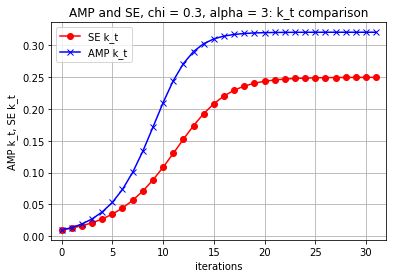

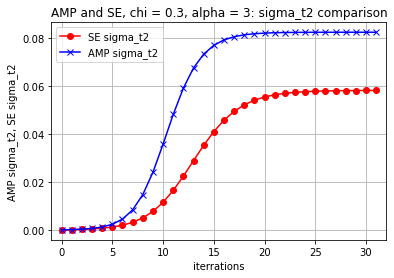

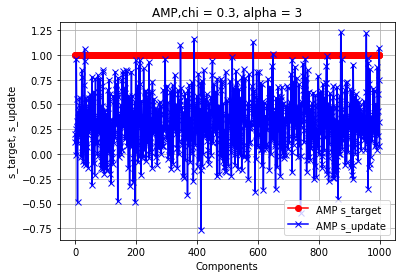

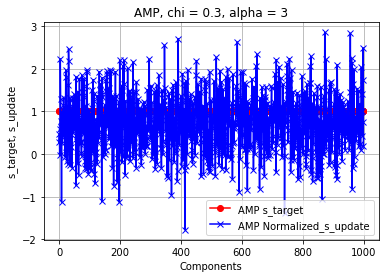

--- 4683.079322814941 seconds_plots over ---


In [14]:
# Homework6(AMP and SE - pre-store y^* second version fixed chi comparison) - alhpa=3
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

#hash table: pre-store all the possible y^*
def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

hash_y = dict()
keyIdx = []
for i in np.arange(0,20,0.0001):
    keyIdx.append(round(i,4))
for j in keyIdx:
    hash_y[j]=y_s(j,0.3)
print("--- %s seconds_pre-store ---" % (time.time() - start_time))

#sampling
n = 1000  # dimension
m = 3000  # data
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)

def F(p, t):
    if p>0:
        return hash_y[p]/np.sqrt(t)
    else:
        return -hash_y[abs(p)]/np.sqrt(t)

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def update_p(s, p, chi):
    p_d = np.zeros(m)
    for u in range(m):
        p_d[u] = round((1/np.sqrt(n))*x[u]@s - chi*F(p[u],chi),4)
    return p_d

def update_s(s, p, chi):
    s_d = np.zeros(n)
    for i in range(n):
        sum_ = 0
        for j in range(m):
            sum_ += chi*((1/np.sqrt(n))*x[j][i]*F(p[j],chi) -(1/n)*s[i]*x[j][i]**2*T(p[j],chi))
        s_d[i] = sum_
    return s_d

def amp2(chi):
    s_0 = np.zeros(n)  
    p_0 = np.zeros(m)
    eps=1e-6
    iter_amp2 = 0
    p_new = np.zeros(m)
    s_new = 0.01*np.ones(n)
    def sigma2_update(s_new):
        sigma2_up = 0
        for i in range(n):
            sigma2_up += LA.norm(s_new[i] - k_collect_amp2[iter_amp2])**2/n
        return sigma2_up
    while LA.norm(s_new[0] - s_0[0])>eps:
        p_collect_amp2.append(p_new)
        s_collect_amp2.append(s_new)
        k_collect_amp2.append(s_new@s_Ori/n)
        sigma2_collect_amp2.append(sigma2_update(s_new))
        s_0 = s_new
        p_0 = p_new
        p_new = update_p(s_0,p_0, chi)
        s_new = update_s(s_0,p_new, chi)
        iter_amp2 +=1
    return s_collect_amp2,p_collect_amp2,k_collect_amp2,sigma2_collect_amp2,iter_amp2

def se2(chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in range(-50,51,1):
            sum_f += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)/np.sqrt(2*np.pi)
            sum_f2 += np.exp(-1/2*z**2)*F(round(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,4),chi)**2/np.sqrt(2*np.pi)
        k_new = alpha*chi*sum_f
        sigma_new = alpha*chi**2*sum_f2
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

print("--- %s seconds_start se ---" % (time.time() - start_time))
se2_update = se2(0.3)
print("--- %s seconds_se over-amp start ---" % (time.time() - start_time))
amp2_update = amp2(0.3)
print("--- %s seconds_amp over ---" % (time.time() - start_time))

idx_se2 = []
for index in range(se2_update[2]+1):
    idx_se2.append(index)

idx_amp2 = []
for index in range(amp2_update[4]):
    idx_amp2.append(index)

idx = []
for index in range(n):
    idx.append(index)

iterMin = min(len(idx_se2),len(idx_amp2))   
print("--- %s seconds_plots ---" % (time.time() - start_time))

#figure-1    
plt.plot(idx_se2[:iterMin],se2_update[0][:iterMin],c="r",label="SE k_t",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[2][:iterMin],c="b",label="AMP k_t",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: k_t comparison")
plt.ylabel("AMP k_t, SE k_t")
plt.xlim(-1,iterMin)
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()

#figure-2
plt.plot(idx_se2[:iterMin],se2_update[1][:iterMin],c="r",label="SE sigma_t2",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[3][:iterMin],c="b",label="AMP sigma_t2",marker="x")
plt.title("AMP and SE, chi = 0.3, alpha = 3: sigma_t2 comparison")
plt.ylabel("AMP sigma_t2, SE sigma_t2")
plt.xlabel("iterrations")
plt.xlim(-1,iterMin)
plt.grid()
plt.legend()
plt.show()

#figure-3
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,amp2_update[0][-1],c="b",label="AMP s_update",marker="x")
plt.title("AMP,chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()

#figure-4 Normalized_S
normalized_S = np.sqrt(n)* amp2_update[0][-1]/LA.norm(amp2_update[0][-1])
plt.plot(idx,s_Ori,c="r",label="AMP s_target",marker="o")
plt.plot(idx,normalized_S,c="b",label="AMP Normalized_s_update",marker="x")
plt.title("AMP, chi = 0.3, alpha = 3")
plt.ylabel("s_target, s_update")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()
print("--- %s seconds_plots over ---" % (time.time() - start_time))